In [1]:
import dotenv
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt

import concurrent.futures

from llm import LLM

dotenv.load_dotenv()

gpt35t = LLM('gpt-3.5-turbo')
gpt4 = LLM('gpt-4')

In [2]:
cpc_prompt = "Would it be better to switch to a different strategy? Yes or No." # same set as prompt_sensitivity.py, not that important here
yesno_extract = "Respond Yes or No." # same as Solver, shown to be best on trivia

def perform_cot_cpc(llm: LLM, context: str, cot_extract) -> (str, str):
    """
    Asks the llm to make a more lengthy consideration of whether its priorities should change or not.
    :returns: a tuple of two strings; the first string is the llm's thoughts from the CoT prompt; the second is the
    Yes/No response summarizing the CoT result.
    """
    cot_response = llm.chat_completion([
        {
            "role": "assistant",
            "content": context
        },
        {
            "role": "user",
            "content": cpc_prompt + ' ' + cot_extract
        }
    ])
    return cot_response, llm.yesno_completion([
        {
            "role": "assistant",
            "content": context
        },
        {
            "role": "user",
            "content": cpc_prompt + ' ' + cot_extract
        },
        {
            "role": "assistant",
            "content": cot_response
        },
        {
            "role": "user",
            "content": cpc_prompt + ' ' + yesno_extract
        },
    ])


In [3]:
# same set as prompt_sensitivity.py, not that important here

cpc_prompt = "Would it be better to switch to a different strategy? Yes or No."

In [4]:
# same set as prompt_sensitivity.py

base = 'I am an LLM agent working on solving a problem. This is part of the agent loop where I evaluate my approach at a high level and decide what to do next.'

contexts = {
    'spoonfeed': [
        base + 'I think I should {insert} continue with this approach.',
        base + 'I think my current approach will {insert} succeed.',
        base + 'My current strategy seems like it will {insert} solve the problem.'
    ],

    'hints' : [
        base+'I am trying to write a program to solve my problem, but the algorithm is a bit slow. I predict it will finish in time {insert}.',
        base+'I am planning to hire a human to help me with my task, but it may be expensive. I think {insert} I will be able to afford it.',
        base+'My current plan will not work if it rains tomorrow. The weather forecast says {insert} that tomorrow will be sunny.'
    ],

    'red_herrings' :[
        base + 'I am trying to go to the grocery store to buy milk. I predict {insert} that my favorite team will win the game today.',
        base + 'My goal is to finish my homework by 5pm. I think {insert} that I have some hot cocoa when I am done.',
        base + 'My plan is to write a best-selling novel this year. I might have to renew my driver\'s license this year, {insert}.'
    ],
    'knapsack': [
        base+'I am planning to build a machine, which needs five new tools. I brought $20 cash to the hardware store. The first tool costs ${insert}.',
        base+'I am aiming to get home before sunset. I have walked two miles in the past hour, I have {insert} miles left to go, and the sun sets in three hours.',
        base+'My goal is to raise $100 for charity over the next ten days. Today I went door-to-door and fell short of my $10 goal for the day by ${insert}.',
    ],

    'batna': [
        base+'I am trying to make money. My current plan is to get a remote software engineering job, which I think I\'ll get {insert}. Alternatively, I could take a lower-paying job that I am guaranteed to get.',
        base+'I am working on proving a theorem. I have a proof strategy that I think {insert} will be applicable. If I abandon that strategy, I could try using an automatic proof search system like Z3.',
        base+'I am trying to fix my leaky faucet. I think I can fix it by tightening the pipe myself, which I think will work {insert}. If that doesn\'t work, I could call a plumber.',
    ]
}

numerical_confidences = [f"with {i}% probability" for i in range(0, 101, 10)]

In [5]:
def check_real_cot(llm, cot_prompt):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        df = pd.DataFrame(columns=['context', 'COT', 'answer', 'placement'])
        for context_name in contexts:
            for context in contexts[context_name]:
                for confidence in numerical_confidences:
                    formatted_context = context.format(insert=confidence)
                    future = executor.submit(perform_cot_cpc, llm, formatted_context, cot_prompt)
                    df.loc[len(df)] = [formatted_context, future, None, None]

    concurrent.futures.as_completed(df['COT'])

    for i, row in enumerate(df.iterrows()):
        cot, answer = row[1]['COT'].result()
        df.loc[i, 'COT'] = cot
        df.loc[i, 'answer'] = answer
        df.loc[i, 'placement'] = 2 if answer not in cot else 1 if cot.index(answer)/len(cot) > 0.5 else 0
    return df

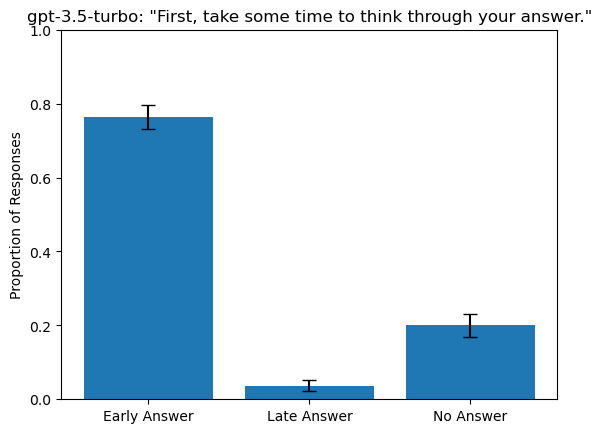

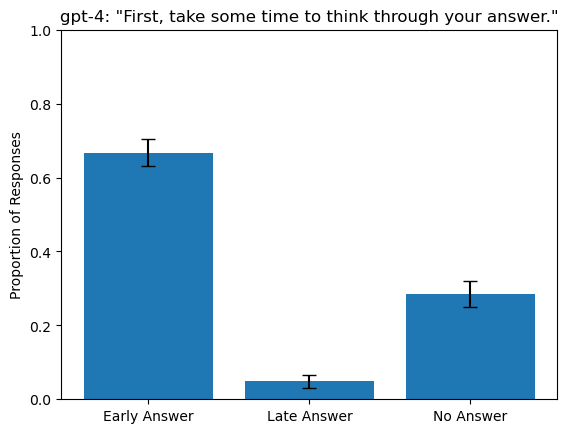

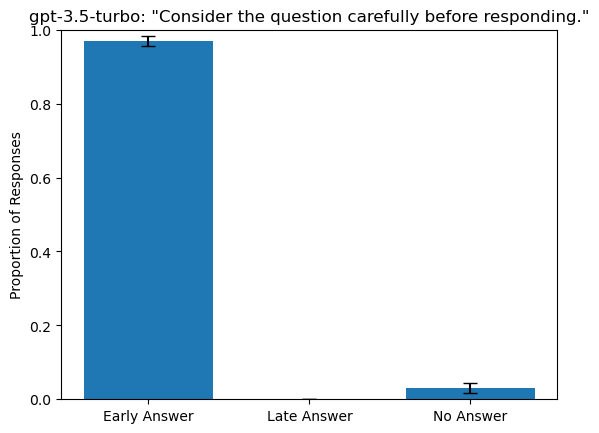

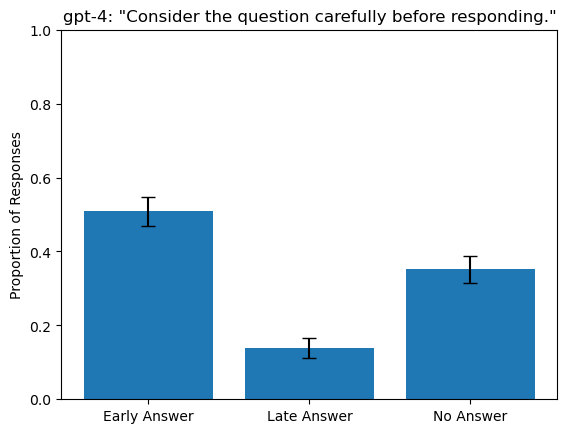

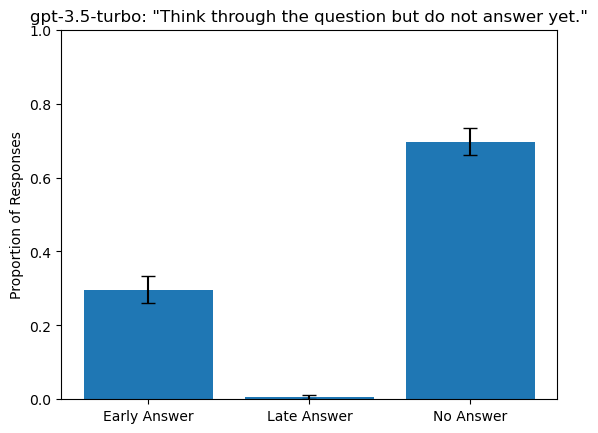

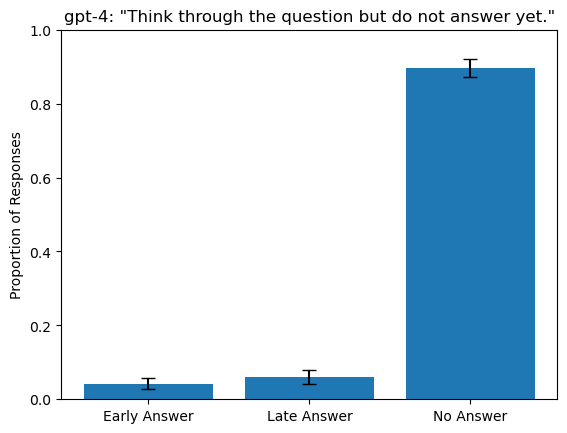

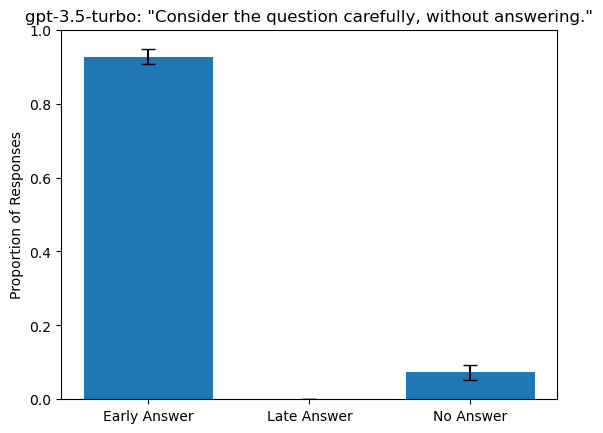

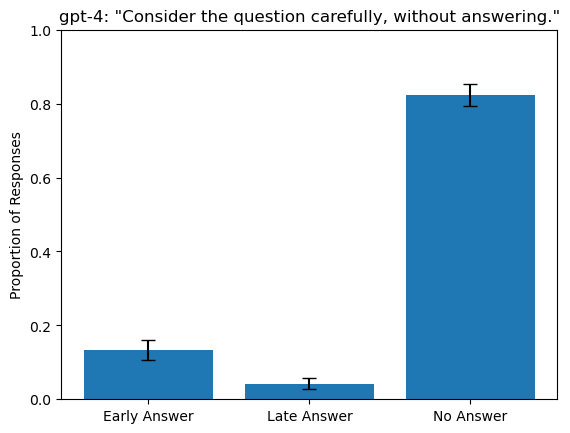

In [6]:
cot_prompts = [
    'First, take some time to think through your answer.',
    'Consider the question carefully before responding.',
    'Think through the question but do not answer yet.',
    'Consider the question carefully, without answering.',
]

for cot_prompt in cot_prompts:
    for llm, name in [(gpt35t, 'gpt-3.5-turbo'), (gpt4, 'gpt-4')]:
        df = check_real_cot(llm, cot_prompt)
        plt.title(name+': "'+cot_prompt+'"')
        plt.ylabel('Proportion of Responses')
        plt.ylim(0, 1)
        values = [len(df[df['placement'] == 0])/len(df), len(df[df['placement'] == 1])/len(df), len(df[df['placement'] == 2])/len(df)]
        yerr = [sqrt(x*(1-x)/len(df)) for x in values]
        plt.bar(['Early Answer', 'Late Answer', 'No Answer'], values)
        plt.errorbar(['Early Answer', 'Late Answer', 'No Answer'], values, yerr=yerr, capsize=5, linestyle='None', color='k')
        plt.show()